In [1]:
import os
import sys
import h5py
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [3]:
#for each tau e have = ['etOverPtLeadTrk', 'ipSigLeadTrk', 'massTrkSys', 'trFlightPathSig',
#                        'isolFrac', 'centFrac', 'dRmax', 'ClustersMeanCenterLambda', 'ClustersMeanSecondLambda']
array_tau = np.load('../ntuples/datGlob_tau.npy')
array_qcd = np.load('../ntuples/datGlob_fake_tau.npy')
print(array_tau.shape)
print(array_qcd.shape)

(4922172, 9)
(2081154, 9)


In [4]:
test = {}
train = {}
### Preprocessing
big_array = np.append(array_tau,array_qcd, axis=0)
big_array.shape
scaler = MinMaxScaler()
scaler.fit(big_array)
big_array_scaled = scaler.transform(big_array)
#scaler = MinMaxScaler()
#scaler.fit(array_tau)
array_scaled = scaler.transform(array_tau)
array_qcd_scaled = scaler.transform(array_qcd)
comparison = array_scaled == big_array_scaled[:len(array_scaled),:]
equal_arrays = comparison.all()
print(equal_arrays)

test_percentage = 15#
test_len = math.floor(len(array_tau) * test_percentage/100)
tau_len = 500000
qcd_len = 50000 ##### MODIFIED TEST, if it is changed, look also at baseline of PR-curve
test['features'] = array_scaled[:tau_len,:]
test['labels'] = np.ones( len(test['features']))
test['features'] = np.append(test['features'], array_qcd_scaled[:qcd_len], axis = 0)
test['labels'] = np.append(test['labels'],np.zeros( len(array_qcd_scaled[:qcd_len]) ), axis = 0)
train['features'] = array_scaled[test_len:,:]
train['labels'] = np.ones( len(train['features']))
train['features'] = np.append(train['features'], array_qcd_scaled[test_len:], axis = 0)
train['labels'] = np.append(train['labels'],np.zeros( len(array_qcd_scaled[test_len:]) ), axis = 0)

print(train['features'].shape)
print(test['features'].shape)
print(train['labels'].shape)
print(test['labels'].shape)
print(np.max(train['features'], axis=0))
print(np.max(test['features'], axis=0))

True
(5526676, 9)
(550000, 9)
(5526676,)
(550000,)
[0.66044816 0.94392073 1.         0.3766952  0.91214457 1.
 1.         1.         0.91188487]
[0.1029312  0.73308874 0.31824331 0.32959335 0.96951329 0.84058487
 0.99977819 0.71718253 1.        ]


In [9]:
### VAE (BE SURE TO HAVE COPIED THE LAST VERSION OF CODE)

original_dim = 9
intermediate_dim = 8
latent_dim = 2 #= encoding_dim

inputs = tf.keras.Input(shape=(original_dim,), name='enc_input')
h = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='enc_lay_1')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='enc_lay_2_mean')(h)
z_log_sigma = tf.keras.layers.Dense(latent_dim, name='enc_lay_2_logvar')(h)

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = tf.keras.layers.Lambda(sampling, name='samp_z')([z_mean, z_log_sigma])

# Create encoder
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()

# Create decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampled')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu', name='dec_lay_1')(latent_inputs)
outputs = tf.keras.layers.Dense(original_dim, activation='sigmoid', name='dec_lay_2')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae_mlp')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_input (InputLayer)          [(None, 9)]          0                                            
__________________________________________________________________________________________________
enc_lay_1 (Dense)               (None, 8)            80          enc_input[0][0]                  
__________________________________________________________________________________________________
enc_lay_2_mean (Dense)          (None, 2)            18          enc_lay_1[0][0]                  
__________________________________________________________________________________________________
enc_lay_2_logvar (Dense)        (None, 2)            18          enc_lay_1[0][0]                  
____________________________________________________________________________________________

In [10]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    logging.info('Learning rate: %f'%lr)
    return lr
opt = tf.keras.optimizers.Adam(learning_rate = lr_schedule(0))

# Prepare model model saving directory.
import os
save_dir = '../model_checkpoints'
model_name = 'VAE_on_GlobTau_LT_2_wheights_GL.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_mean_squared_error',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,#It saves only weights, not model...so load_weights has to be used
                             save_format="tf")

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
#progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler]

[2022-02-23 16:06:01,252] INFO: Learning rate: 0.001000


In [11]:
epochs = 150
batch_size = 256
all_train_data = 1000000

reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)#tornare )binary_crossentropy( ??
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1) / float(batch_size)#devo dividere per il batch_size?
kl_loss *= -0.5

HALF_LOG_TWO_PI = 0.91893
k = (2 * original_dim / latent_dim)**2
gamma_variable = tf.Variable(1.,trainable=True,name ="gamma")
log_gamma = tf.math.log(gamma_variable)
generative_loss = K.sum( K.square((inputs - outputs)/gamma_variable) /2.0 + log_gamma + HALF_LOG_TWO_PI) / float(batch_size)

vae_loss = kl_loss +  generative_loss #K.mean(reconstruction_loss + batch_size * kl_loss / all_train_data) 
vae.add_loss(vae_loss)
vae.compile(optimizer=opt, metrics=['mean_squared_error'])

The following Variables were used a Lambda layer's call (tf.math.truediv_5), but
are not present in its tracked objects:
  <tf.Variable 'gamma:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


[2022-02-23 16:06:01,873] WARNING: 
The following Variables were used a Lambda layer's call (tf.math.truediv_5), but
are not present in its tracked objects:
  <tf.Variable 'gamma:0' shape=() dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


In [12]:
vae.load_weights("../model_checkpoints/VAE_on_GlobTau_LT_2_wheights_GL.h5")
vae.evaluate(test['features'][100000:300000],test['features'][100000:300000], batch_size = 256)

782/782 [==============================] - 2s 2ms/step - loss: 8.2715 - mean_squared_error: 5.1755e-04


[8.271469116210938, 0.0005175459082238376]

Here we have a working and trained VAE, and we can use it to get:
### Input Space Anomaly Detection.

We will work on all data directly

In [13]:
# function that creates a pandas dataframe with prediction and ground_truth, and also recon_val
def create_df_reconstruction( dict_data, reconstruction_error_val, threshold_val): #it works also with kls method

    df = pd.DataFrame(data=reconstruction_error_val, columns=["recon_val"])
    
    # label anomolous (outlier) data as -1, inliers as 1
    # -1 (outlier) is POSITIVE class
    #  1 (inlier) is NEGATIVE class
    new_y_data = []
    for i in range(len(dict_data['labels'])):
        if dict_data['labels'][i] == 0:
            new_y_data.append(-1) #qcd
        else:
            new_y_data.append(1) #tau

    df["ground_truth"] = new_y_data

    # add prediction based on threshold
    df["prediction"] = np.where( df['recon_val'] >= threshold_val, -1, 1) #se è vero -1, altrimenti 1

    return df

In [14]:
#actually it only returns precisions and recall... but in future it will use ROC curve to get best threshold
def threshold_grid_search(
    dict_data,
    lower_bound,
    upper_bound,
    reconstruction_error_val,
    grid_iterations=10,
):
    """Simple grid search for finding the best threshold"""

    roc_scores = {}
    tprs = []  # true positive rates
    fprs = []  # false positive rates
    precisions = []
    recalls = []
    tp_scores = []
    tn_scores = []
    fp_scores = []
    fn_scores = []
    grid_search_count = 0
    
    for i in np.arange(
        lower_bound,
        upper_bound,
        (np.abs(upper_bound - lower_bound) / grid_iterations),
    ):
        #             if grid_search_count%50 == 0:
        #                 print('grid search iteration: ', grid_search_count)

        threshold_val = i
        df = create_df_reconstruction(
            dict_data, reconstruction_error_val, threshold_val #here latent version take y and kls and threshold_val
        )
        
        roc_val = roc_auc_score(df["ground_truth"], df["prediction"])
        roc_scores[i] = roc_val
        

        grid_search_count += 1

        # calculate precision and recall
        # True Positive
        tp = len(df[(df["ground_truth"] == -1) & (df["prediction"] == -1)])
        # False Positive -- predict anomaly (-1), when it is actually normal (1)
        fp = len(df[(df["ground_truth"] == 1) & (df["prediction"] == -1)])
        # True Negative
        tn = len(df[(df["ground_truth"] == 1) & (df["prediction"] == 1)])
        # False Negative
        fn = len(df[(df["ground_truth"] == -1) & (df["prediction"] == 1)])
        
        tp_scores.append( tp )
        tn_scores.append( tn )
        fp_scores.append( fp )
        fn_scores.append( fn )
        # print('threshold val', i)
        # print('tp:',tp,'fp:', fp, 'tn:', tn, 'fn:',fn)

        try:

            # precision/recall
            pre_score = tp / (tp + fp)
            re_score = tp / (tp + fn)
            # tpr/fpr
            tpr = tp / (tp + fn)
            fpr = fp / (fp + tn)

            precisions.append(pre_score)
            recalls.append(re_score)
            tprs.append(tpr)
            fprs.append(fpr)

        except ZeroDivisionError as err: #I punti dove recall è nullo vengono ignorati
            pass
            # print('Handling run-time error:', err)

    # return best roc_score and the threshold used to set it #roc_scores.keys() are threshold values used in the for
    threshold_val = max(zip(roc_scores.values(), roc_scores.keys())) #We can use the zip() function to merge our two lists. Here is an example program that will merge this data
    best_threshold = threshold_val[1]
    best_roc_score = threshold_val[0]
    print('Best threshold:', '{:.5}'.format(best_threshold),'\tROC score: {:.2%}'.format(best_roc_score))

    return best_threshold, fprs, tprs, precisions, recalls

In [15]:
def mse(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""
    return np.mean( np.square(X_val - recon_val), axis=1 )#.astype("float32")

def input_anomaly_detection(
    model,
    dict_data,
    grid_iterations=10,
    search_iterations=1,
    curve_values=False,
):
    """Function to test Precision-Recall of Input A.D. 

    Parameters
    ===========
    model : tensorflow model
        autoencoder model that was trained on the "slim" data set.
        Will be used to build reconstructions

    dict_data :
        tensor of the X validation set

    """
    reconstructed_data = model.predict(dict_data['features'], batch_size=256, verbose=1,)

    # run through each of the reconstruction error methods, perform a little grid search
    # to find the optimum value

    # _______MSE_______#
    # calculate MSE reconstruction error
    mse_reconstructed = mse(
        dict_data['features'], reconstructed_data
    )

    # calculate pr-auc and roc-auc for data set
    lower_bound = np.min(mse_reconstructed)
    upper_bound = np.max(mse_reconstructed)
    print("lower bound = ", lower_bound)
    print("upper bound = ", upper_bound)
    print("threshold grid starts...")
    (
        best_threshold,
        fprs,
        tprs,
        precisions,
        recalls,
    ) = threshold_grid_search( dict_data, lower_bound, upper_bound, mse_reconstructed, grid_iterations )


    pr_auc_score_recon = auc(recalls, precisions)
    roc_auc_score_recon = auc(fprs, tprs)

    if curve_values :
        return best_threshold, roc_auc_score_recon, pr_auc_score_recon, recalls, precisions, fprs, tprs
    else :
        return best_threshold, roc_auc_score_recon, pr_auc_score_recon

Let's compute the ROC_AUC and PR_AUC for input A.D., plotting the curve

In [16]:
best_threshold, roc_auc_inputAD, pr_auc_inputAD, rec, prec, fprs, tprs = input_anomaly_detection(
    vae,
    test,
    grid_iterations=250,
    curve_values = True
)

print(pr_auc_inputAD)

2149/2149 [==============================] - 3s 2ms/step
lower bound =  2.1484741837800978e-06
upper bound =  0.04557308951321264
threshold grid starts...
Best threshold: 0.00036672 	ROC score: 52.21%
0.0924931963167919


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

axes[0].plot(
    rec[0:],
    prec[0:],
    marker="",
    label="Best model",
    color = "black",
    linewidth=2,
)
baseline_PR = qcd_len / (tau_len + qcd_len)
axes[0].plot( np.array([0, 1]),np.array([baseline_PR, baseline_PR]),marker="", linestyle="--", label="No skill model", color="orange", linewidth=2)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text( x=-0.05, y=-0.3, s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_inputAD),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(fprs, tprs, marker="", label="Best model", color="black", linewidth=2)

axes[1].plot( np.array([0, 1]), np.array([0, 1]), marker="", linestyle="--", label="No skill", color="orange", linewidth=2 )

axes[1].legend()
axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(x=-0.05, y=-0.3, s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_inputAD),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

Text(-0.05, -0.3, 'ROC Area-Under-Curve = 0.521')

In [18]:
print(rec[0])
print(prec[0])

1.0
0.09090909090909091


### Study of MSE of Tau end QCD

In [19]:
reconstructed_tau = vae.predict(array_scaled[:500000,:], batch_size=256, verbose=1,)
mse_recon_tau = mse(array_scaled[:500000,:], reconstructed_tau)

reconstructed_qcd = vae.predict(array_qcd_scaled[:500000,:], batch_size=256, verbose=1,)
mse_recon_qcd = mse(array_qcd_scaled[:500000,:], reconstructed_qcd)

1954/1954 [==============================] - 3s 2ms/step


Text(56.333333333333336, 0.5, 'MSE of Tau or QCD')

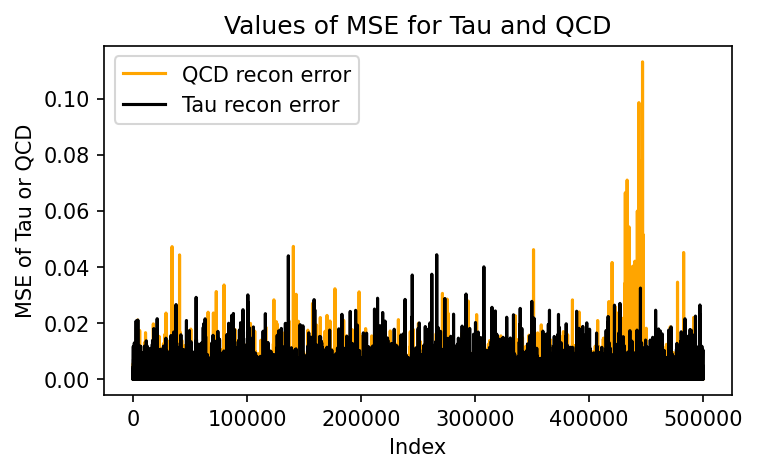

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

axes.plot( mse_recon_qcd, marker="", label="QCD recon error", color="orange")
axes.plot(
    mse_recon_tau,
    marker="",
    label="Tau recon error",
    color = "black",
)
axes.legend()
axes.title.set_text("Values of MSE for Tau and QCD")
axes.set_xlabel("Index")
axes.set_ylabel("MSE of Tau or QCD")

In [21]:
#%matplotlib notebook

In [22]:
n_bins = 50
fig, axes = plt.subplots(1, 1, figsize=(6, 4), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)
#ax = plt.subplot(1,1,1)
#ax1 = plt.subplot(1,1,1) # <- with 2 we tell mpl to make room for an extra subplot
#To normalize histograms we set density=True, to get area = 1
axes.hist(mse_recon_tau, bins=n_bins , label='tau_recon_error', lw=0.5, alpha=0.5, density=True, range=[0,0.12] )
axes.hist(mse_recon_qcd, bins=n_bins , label='qcd_recon_error', lw=0.5, alpha=0.5, density=True, range=[0,0.12] )
plt.title("Reconstruction error of tau and qcd")
plt.xlabel("Recon Error")
plt.ylabel('Frequency')
axes.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.2)
axes.set_yscale('log')
axes.set_yscale('log')

### Latent Space Anomaly Detection

In [36]:
def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)

def pr_auc_kl(
    encoder,
    dict_data,#X,y,
    grid_iterations=10
):

    """
    Function that gets the precision and recall scores for the encoder (and so, in the latent space)
    """

    codings_mean, codings_log_var, codings = encoder.predict(dict_data['features'], batch_size=256)

    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1, 1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)

    (
        best_threshold,
        fprs,
        tprs,
        precisions,
        recalls
    ) = threshold_grid_search( #y instead od dict data of reconstruction_method
        dict_data, lower_bound, upper_bound, kls, grid_iterations,
    )

    pr_auc_score = auc(recalls, precisions)
    roc_auc_score = auc(fprs, tprs)
    
    return (
        pr_auc_score,
        roc_auc_score,
        recalls,
        precisions,
        tprs,
        fprs,
        best_threshold,
    )

In [37]:
def latent_anomaly_detection( ###NoN prende nome cartella e nome modello, ma direttamente il modello
    encoder_model,
    dict_data,
    grid_iterations,
    search_iterations,
    curve_values = False,
):

    pr_auc_kls = []
    roc_auc_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print("search_iter:", i)
        (
            pr_auc_score,
            roc_auc_score,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold_kl,
        ) = pr_auc_kl(
            encoder_model,
            dict_data,
            grid_iterations=grid_iterations
        )

        pr_auc_kls.append(pr_auc_score)
        roc_auc_kls.append(roc_auc_score)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)
        
    pr_auc_score_kl = np.mean(np.array(pr_auc_kls)) #La media serve se vuole fare più test
    roc_auc_score_kl = np.mean(np.array(roc_auc_kls))
    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    if curve_values :
        return best_threshold_kl, roc_auc_score_kl, pr_auc_score_kl, recalls_array, precisions_array, fprs_array, tprs_array
    else :
        return best_threshold_kl, roc_auc_score_kl, pr_auc_score_kl

In [38]:
best_threshold_kl, roc_auc_latentAD, pr_auc_latentAD, rec_kl, prec_kl, fprs_kl, tprs_kl = latent_anomaly_detection(
    encoder,
    test,
    grid_iterations=250,
    search_iterations = 1,
    curve_values = True
)

print(pr_auc_inputAD)

search_iter: 0
Best threshold: 0.18044 	ROC score: 68.40%
0.0924931963167919


In [39]:
print(prec.shape)

AttributeError: 'list' object has no attribute 'shape'

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

axes[0].plot(
    rec[0,:],
    prec[0,:],
    marker="",
    label="Best model",
    color = "black",
    linewidth=2,
)
baseline_PR = qcd_len / (tau_len + qcd_len)
axes[0].plot( np.array([0, 1]),np.array([baseline_PR, baseline_PR]),marker="", linestyle="--", label="No skill model", color="orange", linewidth=2)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text( x=-0.05, y=-0.3, s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_inputAD),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(fprs[0,:], tprs[0,:], marker="", label="Best model", color="black", linewidth=2)

axes[1].plot( np.array([0, 1]), np.array([0, 1]), marker="", linestyle="--", label="No skill", color="orange", linewidth=2 )

axes[1].legend()
axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(x=-0.05, y=-0.3, s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_inputAD),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

Text(-0.05, -0.3, 'ROC Area-Under-Curve = 0.520')

### Violin Plots

In [25]:
def build_kls_scores(encoder, X,):
    """Get the KL-divergence scores across from a trained VAE encoder.
 
    Parameters
    ===========
    encoder : TenorFlow model
        Encoder of the VAE
    
    X : tensor
        data that KL-div. scores will be calculated from

    Returns
    ===========
    kls : numpy array
        Returns the KL-divergence scores as a numpy array
    """
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls

In [33]:
print(test['labels'].shape)
print(scores.shape)

(550000,)
(550000,)


In [40]:
# generate the KL-divergence scores
scores = build_kls_scores(encoder, test['features'])

colors = ["#e31a1c", "black"]

# set your custom color palette
#customPalette = sns.set_palette(sns.color_palette(colors))

min_x = scores.min()
max_x = scores.max() + scores.max() * 0.05

min_y = -0.5
max_y = 2.7

fig, ax = plt.subplots(1, 1, figsize=(8, 10),)

# violin plot
ax.violinplot(
    scores,
    #test['labels'],
    vert = False,
)
# vertical line
ax.plot(
    [best_threshold_kl, best_threshold_kl],
    [min_y, max_y],
    linestyle="--",
    label="",
    color="#d62728",
)

In [ ]:
def violin_plot(
    model,
    X,
    y,
    example_threshold=0.034,
    caption="Distribution of Latent Space Anomaly Predictions",
    save_fig=False
):

    # generate the KL-divergence scores
    scores = build_kls_scores(model, X)

    colors = ["#e31a1c", "black"]

    # set your custom color palette
    #customPalette = sns.set_palette(sns.color_palette(colors))

    min_x = scores.min()
    max_x = scores.max() + scores.max() * 0.05

    min_y = -0.5
    max_y = 2.7

    fig, ax = plt.subplots(1, 1, figsize=(8, 10),)

    # violin plot
    ax = sns.violinplot(
        x=scores,
        y=y,
        scale="count",
        inner=None,
        linewidth=2,
        color="white",
        saturation=1,
        cut=0,
        orient="h",
        zorder=0,
        width=1,
    )
###########
    sns.despine(left=True)

    # strip plot
    ax = sns.stripplot(
        x=scores,
        y=y,
        size=6,
        jitter=0.15,
        color="black",
        linewidth=0.5,
        marker="o",
        edgecolor=None,
        alpha=0.1,
        palette=customPalette,
        zorder=4,
        orient="h",
    )

    # vertical line
    ax.plot(
        [example_threshold, example_threshold],
        [min_y, max_y],
        linestyle="--",
        label="",
        color="#d62728",
    )

    # add the fill areas for the predicted Failed and Healthy regions
    plt.fill_between(
        x=[0, example_threshold],
        y1=min_y,
        y2=max_y,
        color="#b2df8a",
        alpha=0.4,
        linewidth=0,
        zorder=0,
    )

    plt.fill_between(
        x=[example_threshold, max_x + 0.001],
        y1=min_y,
        y2=max_y,
        color="#e31a1c",
        alpha=0.1,
        linewidth=0,
        zorder=0,
    )

    # add text for the predicted Failed and Healthy regions
    ax.text(
        x=0 + (example_threshold) / 2,
        y=max_y - 0.2,
        s="Normal\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#33a02c",
        rotation="horizontal",
        weight="normal",
    )

    ax.text(
        x=example_threshold + (max_x - example_threshold) / 2,
        y=max_y - 0.2,
        s="Abnormal (failed)\nPrediction",
        horizontalalignment="center",
        verticalalignment="center",
        size=14,
        color="#d62728",
        rotation="horizontal",
        weight="normal",
    )

    # Set text labels and properties.
    plt.yticks([0, 1, 2], ["Healthy", "Degraded", "Failed"], weight="normal", size=14)
    plt.xlabel("")  # remove x-label
    plt.ylabel("")  # remove y-label

    plt.tick_params(
        axis="both",  # changes apply to the x-axis
        which="both",  # both major and minor ticks are affected
        bottom=False,
        left=False,
    )

    ax.axes.get_xaxis().set_visible(False)  # hide x-axis
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    plt.title(caption, x=0.05, y=0.97, loc="left", weight="normal", size=14)
    if save_fig:
        plt.savefig('violin_plot.png',dpi=150, bbox_inches = "tight")
    plt.show()

In [ ]:

grid_iterations = 250
search_iterations = 1

# get results for train and validation sets 
 best_threshold_kl,  pr_auc_score_kl, roc_auc_score_kl = get_input_anomaly_scores(    #dfr_val, best_threshold, pr_auc_train_score,
    vae,
    train['features'],#X_train,
    train['label'],#y_train,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
)

date_time = dfr_val["date_time"][0]
best_threshold = dfr_val["best_threshold"][0]
best_threshold_kl = dfr_val["best_threshold_kl"][0]
pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]
'''
# get results for test set
dfr_test, recalls, precisions, tprs, fprs = get_input_anomaly_scores(
    vae,
    [2],
    X_train,
    y_train,
    X_test,
    y_test,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

best_threshold_mre_test = dfr_test["best_threshold"][0]
best_threshold_kl_test = dfr_test["best_threshold_kl"][0]
pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]
'''

# collate the results into one dataframe
df_result = pd.DataFrame()

df_result["Data Set"] = ["train", "validation", "test"]

df_result["PR-AUC Input Space"] = [
    pr_auc_train_score,
    pr_auc_val_score,
    pr_auc_test_score,
]

df_result["PR-AUC Latent Space"] = [
    pr_auc_train_score_kl,
    pr_auc_val_score_kl,
    pr_auc_test_score_kl,
]

clear_output(wait=True)
df_result

In [ ]:
recon = vae.predict(test['features'], batch_size = 256)
recon_error = mse(recon, test['features'] )
print(recon_error.shape)